In [2]:
import os
from pathlib import Path
from mlAusCar.constants import *
from mlAusCar.utils.common import read_yaml, create_dirs
from dataclasses import dataclass
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, FunctionTransformer
pd.set_option('display.max_columns', 5000)
sns.set_style('dark')

In [3]:
%pwd

'd:\\My DL Workstation\\Projects\\Australian Vehicle Prices\\research'

In [4]:
os.chdir('../')
%pwd

'd:\\My DL Workstation\\Projects\\Australian Vehicle Prices'

# Data Modeling:

In [17]:
csv_path = './artifacts/data_ingestion/Australian Vehicle Prices.csv'
df = pd.read_csv(csv_path)

In [ ]:
numeric_cols = ['Year', 'Kilometres', 'Price', 'Engine', 'FuelConsumption', 'CylindersinEngine', 'Doors', 'Seats']

In [ ]:
# dealing with data skew
df[numeric_cols].skew()

Year                       -0.992202
Engine Displacement(L)      1.461935
FuelConsumption(L)/100km    0.649182
Kilometers                  0.922053
CylindersinEngine           1.591460
Doors                      -1.359564
Seats                       0.395330
Price                       5.595892
dtype: float64

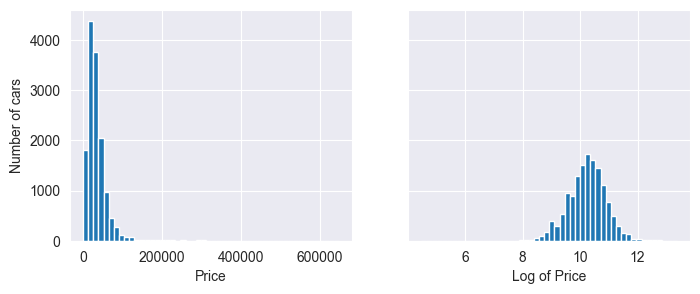

In [ ]:
# High price skew, transforming to fit a Gaussian distribution
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
df["Price"].hist(ax=axs[0], bins=50)
df["Price"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Price")
axs[1].set_xlabel("Log of Price")
axs[0].set_ylabel("Number of cars")
plt.show()

In [ ]:
# Apparently, we would benifit indeed from logging the price
df['Price'] = df["Price"].apply(np.log)

In [ ]:
# splitting into train-test sets
X = df.drop(columns = ['Price'], axis =1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# Transformation pipelines
log_pipeline = make_pipeline(
    FunctionTransformer(func=np.log, feature_names_out='one-to-one'),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown='ignore')
)

num_pipeline = make_pipeline(
    StandardScaler()
)

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

# Modules

In [5]:
# Update entity
@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir: Path
    csv_path: Path

In [6]:
# Update config manager
class ConfigurationManager:
    def __init__(self,
                    config=CONFIG_FILE_PATH,
                    params=PARAMS_FILE_PATH,
                    schema=SCHEMA_FILE_PATH):
        
        self.config= read_yaml(config)
        self.params= read_yaml(params)
        self.schema= read_yaml(schema)
        
        create_dirs(self.config.artifacts_root)
        
    def get_data_transformation_config(self) -> DataTransformationConfig:
        create_dirs(self.config.data_transformation.root_dir)
        
        data_config= DataTransformationConfig(
            root_dir= self.config.data_transformation.root_dir,
            csv_path= self.config.data_transformation.csv_path
        )
        
        return data_config

In [7]:
# Update component
class DataTransformation:
    def __init__(self,
                    config: DataTransformationConfig):
        self.config = config
    
    def transform_data(self):    
        
        # Loading the data:
        csv_path = self.config.csv_path
        df = pd.read_csv(csv_path)

        # Most of the missing values aren't within columns we care about or are few. Safe to drop them
        df.dropna(inplace=True)

        # Location extraction by state to reduce the number of features
        df['State'] = df['Location'].str.extract(r'\, (\w+\-?\w+)')

        # Dropping unnecessary columns
        df.drop(columns=['Brand', 'Car/Suv', 'Title', 'ColourExtInt', 'Location'], axis=1, inplace=True)

        # Extracting fuel consumption number of liters per 100 km
        df['FuelConsumption'] = df['FuelConsumption'].str.extract(r'(\d+\.?\d*) L.*')

        # Extracting engine displacement in L
        df['Engine'] = df['Engine'].str.extract(r'(\d+\.?\d*) L.*')

        # Extracting cylinder count
        df['CylindersinEngine'] = df['CylindersinEngine'].str.extract(r'(\d+) \w+.*')

        # Extracting number of doors
        df['Doors'] = df['Doors'].str.extract(r'(\d+) Doors')

        # Extracting number of seats
        df['Seats'] = df['Seats'].str.extract(r'(\d+) Seats')

        # detecting non-numeric values  in the numeric columns
        numeric_cols = ['Year', 'Kilometres', 'Price', 'Engine', 'FuelConsumption', 'CylindersinEngine', 'Doors', 'Seats']
        for column in numeric_cols:
            nan = {}
            for i, price in zip(df.index, df[column]):
                
                try:
                    float(price)
                    
                except:
                    nan[i] = price 
                    
            # removing non-numeric rows
            df.drop(list(nan.keys()), inplace=True)

        # Detecting missing data in the object columns
        categorical_columns = df.select_dtypes(include='object').columns

        missing = ['-', '0']
        for column in categorical_columns:
            nan = {}
            for i, val in zip(df.index, df[column]):
                # Sometimes the values are 0 for electric cars in FuelConsumption, we keep those
                if not ((df['FuelType'][i] == 'Electric') & (val == '0')):
                    if val in missing:
                        nan[i] = val
                    
            # Removing object columns
            df.drop(list(nan.keys()), inplace=True)

        # type conversion
        for col in numeric_cols:
            try:
                df[col] = df[col].astype(int)
            except:
                df[col] = df[col].astype(float)
                
        # renaming
        df.rename(columns={'Kilometres': 'Kilometers',
                        'Engine': 'Engine Displacement(L)',
                        'FuelConsumption': 'FuelConsumption(L)/100km'}, inplace=True)

        # Reselecting
        numeric_cols = df.select_dtypes(exclude='object').columns
        categorical_columns = df.select_dtypes(include='object').columns

        # Data Modeling:

        # Apparently, we would benefit indeed from logging the price
        df['Price'] = df["Price"].apply(np.log)

        # splitting into train-test sets
        X = df.drop(columns = ['Price'], axis =1)
        y = df['Price']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

        # Transformation pipelines
        log_pipeline = make_pipeline(
            FunctionTransformer(func=np.log, feature_names_out='one-to-one'),
            StandardScaler()
        )

        cat_pipeline = make_pipeline(
            OneHotEncoder(handle_unknown='ignore')
        )

        num_pipeline = make_pipeline(
            StandardScaler()
        )

        preprocessing = make_column_transformer(
            (num_pipeline, make_column_selector(dtype_include=np.number)),
            (cat_pipeline, make_column_selector(dtype_include=object))
        )

        return X_train, y_train, X_test, y_test, log_pipeline, preprocessing

In [8]:
# Update pipeline
try:
    config = ConfigurationManager()
    data_transformation_config= config.get_data_transformation_config()
    data_transformation= DataTransformation(data_transformation_config)
    X_train, y_train, X_test, y_test, log_pipeline, preprocessing =data_transformation.transform_data()
    
except Exception as e:
    raise e

[2023-12-25 20:40:23,418]: INFO: common: .yaml from config\config.yaml has been loaded.
[2023-12-25 20:40:23,419]: INFO: common: .yaml from params.yaml has been loaded.
[2023-12-25 20:40:23,422]: INFO: common: .yaml from schema.yaml has been loaded.
